<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Connect Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import os

# # Change to the directory where project is located
# os.chdir('/content/drive/MyDrive/College/MSc/2nd Semester/Deep Learning/project')

# # Verify that we changed the directory
# print("Changed directory to:", os.getcwd())

## 1.2 Import Libraries

In [ ]:
import pandas as pd
import zipfile
import pickle
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import regularizers
from classes import *
from functions import *

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import optimizers

## 1.3 Import Dataset

The amount of data we have is not supported by GitHub (where we have our project stored). The solution is: create a folder named data and allocate the rare_species file inside it. The gitignore file makes sure this folder is not used when we are pulling or pushing changes but everyone needs to have it on their machines locally. A random seed was used to ensure that the splits stay the same. 

In [ ]:
# # Google Colab

# # Define the path to the zip file and the extraction folder
# zip_path = Path("../data/rare_species.zip")

# # Get the directory where the zip file is located
# extract_path = Path("../data/rare_species")

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [ ]:
# Import Metadata
metadata_path = Path("../data/rare_species/metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [ ]:
df.shape # 11983 images

(11983, 7)

<div class="alert alert-block alert-success">

# **2.** Preprocessing

<div>

- Normalizes pixel values (e.g., rescaling from [0,255] to [0,1]).
- Resizes images to a fixed size (e.g., 224x224 pixels).
- Applies augmentation (only during training).
- Converts images to batches (e.g., batch_size=32 loads 32 images at a time).

In [ ]:
# Load the DataFrames from the .pkl files
# with open("../data/train_df.pkl", "rb") as f:
#     train_df = pickle.load(f)

# with open("../data/valid_df.pkl", "rb") as f:
#     valid_df = pickle.load(f)

# with open("../data/test_df.pkl", "rb") as f:
#     test_df = pickle.load(f)

In [ ]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

In [ ]:
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

train_ds, class_names = preprocess.load_img(data_dir="../data/rare_species/train", minority_class=minority_class, augment='grayscale', oversampling=True)
train_ds_sampled, class_names = preprocess.load_img(data_dir="../data/rare_species/train_sampled", minority_class=minority_class, augment='grayscale', oversampling=True)
val_ds, _ = preprocess.load_img(data_dir="../data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
test_ds, _ = preprocess.load_img(data_dir="../data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

Found 8388 files belonging to 202 classes.
Found 4194 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Found 1798 files belonging to 202 classes.


2025-04-14 17:32:10.228026: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


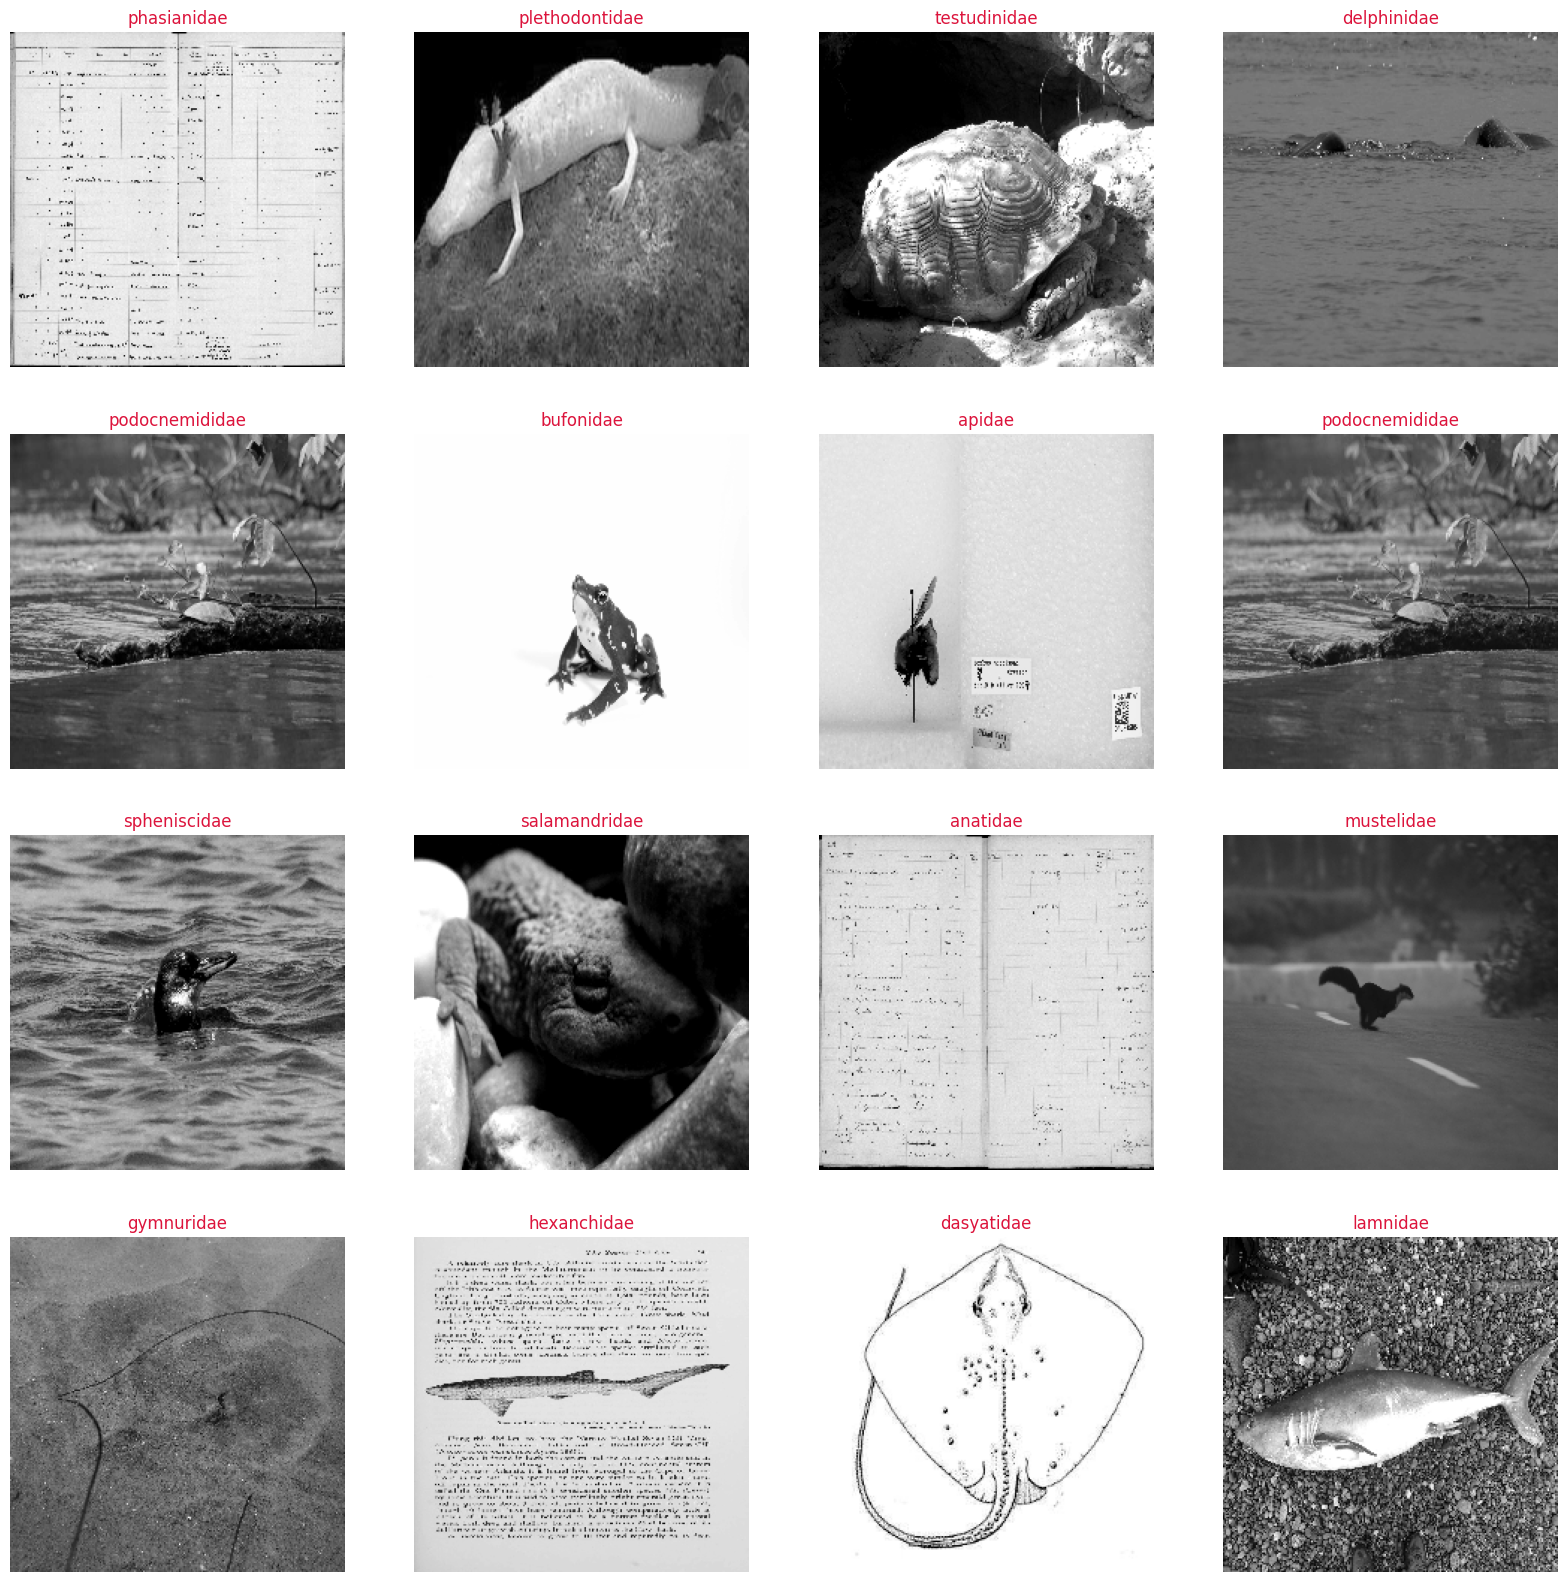

In [ ]:
num_images = 16 ##
rows, cols = 4, 4 ##

plot_batch(train_ds, class_names=class_names, num_images=num_images, rows=rows, cols=cols)

### With Phylum

In [ ]:
# Create the datasets for training, validation, and testing with both image and phylum as inputs
train_ds = build_ds_with_phylum(train_df)
val_ds = build_ds_with_phylum(valid_df)
test_ds = build_ds_with_phylum(test_df)

train_ds

<_PrefetchDataset element_spec=({'image_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), 'phylum_input': TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 202), dtype=tf.float32, name=None))>

## 5.1 Outliers

In [ ]:
# import os
# from glob import glob

# train_dir = Path("../data/rare_species/train")

# image_paths = glob(os.path.join(train_dir, "*", "*.jpg"))  # ou .png dependendo do teu caso

# print(f"Total de imagens encontradas: {len(image_paths)}")

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from tensorflow.keras.preprocessing import image
# from sklearn.cluster import DBSCAN
# import numpy as np
# import cv2

# # Modelo ResNet50 para extrair embeddings
# model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# def extract_embedding(img_path):
#     try:
#         img = image.load_img(img_path, target_size=(224, 224))
#         x = image.img_to_array(img)
#         x = preprocess_input(np.expand_dims(x, axis=0))
#         return model.predict(x, verbose=0)[0]
#     except Exception as e:
#         print(f"Erro com {img_path}: {e}")
#         return None

# # Extrair os embeddings
# embeddings = []
# valid_paths = []

# for path in image_paths:
#     emb = extract_embedding(path)
#     if emb is not None:
#         embeddings.append(emb)
#         valid_paths.append(path)

# embeddings = np.array(embeddings)


In [ ]:
# len(embeddings)

In [ ]:
# from sklearn.metrics.pairwise import pairwise_distances
# import matplotlib.pyplot as plt
# import numpy as np

# # Calcula a matriz de distâncias entre embeddings
# dists = pairwise_distances(embeddings)

# # Para cada ponto, encontra a distância ao seu 5º vizinho mais próximo
# sorted_dists = np.sort(dists, axis=1)
# k_distances = sorted_dists[:, 10]  # min_samples = 5

# # Plot
# plt.figure(figsize=(10, 5))
# plt.plot(np.sort(k_distances))
# plt.title("K-distance plot (5º vizinho)")
# plt.xlabel("Ponto")
# plt.ylabel("Distância ao 5º vizinho")
# plt.grid(True)
# plt.show()


In [ ]:
# from sklearn.cluster import DBSCAN
# import numpy as np

# # DBSCAN: ajusta eps conforme o teu dataset
# clustering = DBSCAN(eps=45, min_samples=10).fit(embeddings)
# labels = clustering.labels_

# # -1 indica outliers
# outliers = np.where(labels == -1)[0]
# outlier_paths = [valid_paths[i] for i in outliers]

# print(f"Número de outliers encontrados: {len(outlier_paths)}")

In [ ]:
# len(outlier_paths)

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# def show_images(image_paths, n=20, cols=5, title="Outliers"):
#     plt.figure(figsize=(15, (n // cols + 1) * 3))
#     for i, img_path in enumerate(image_paths[:n]):
#         img = mpimg.imread(img_path)
#         plt.subplot(n // cols + 1, cols, i + 1)
#         plt.imshow(img)
#         plt.axis("off")
#         plt.title(os.path.basename(img_path), fontsize=8)
#     plt.suptitle(title, fontsize=16)
#     plt.tight_layout()
#     plt.show()

# show_images(outlier_paths, n=100, cols=6)


## 5.2 Augmentations

In [ ]:
# augmentations_to_test = [
#     # "none",
#     # "light",
#     # "medium",
#     # "heavy",
#     # "grayscale",
#     # "randaugment",
#     "mixup",
#     "cutmix"]

<!-- ##### Simple model do test augmentations -->

In [ ]:
# def build_model(num_classes):
#     base = keras.applications.EfficientNetB0(
#         input_shape=(224, 224, 3),
#         include_top=False,
#         weights="imagenet",
#         pooling="avg"
#     )
#     base.trainable = False  # You can fine-tune later

#     inputs = keras.Input(shape=(224, 224, 3))
#     x = base(inputs, training=False)
#     x = keras.layers.Dropout(0.2)(x)
#     outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

#     return keras.Model(inputs, outputs)

In [ ]:
# def sample_dataset(dataset, fraction=None, num_batches=None, seed=42):
#     """Return a sampled subset of the dataset."""
#     if fraction:
#         dataset = dataset.shuffle(1000, seed=seed)
#         dataset = dataset.take(int(fraction * tf.data.experimental.cardinality(dataset).numpy()))
#     elif num_batches:
#         dataset = dataset.take(num_batches)
#     return dataset

<!-- ##### Loop -->

In [ ]:
# # Initialize the preprocessor
# pre = Preprocessor(image_size=(224, 224), batch_size=32)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     # Load datasets
#     train_ds, class_names = pre.load_img(
#         data_dir="../data/rare_species/train",
#         augment=aug
#     )

#     val_ds, _ = pre.load_img(
#         data_dir="../data/rare_species/val",
#         augment=None
#     )

#     # Sample a subset of training data
#     train_ds = sample_dataset(train_ds, fraction=0.5)

#     # Build a fresh model (you should define this function)
#     model = build_sequential_model(list_of_layers=layers)

#     # Compile
#     model.compile(
#         optimizer="adam",
#         loss="categorical_crossentropy",
#         metrics=["accuracy"]
#     )

#     # Train
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=5,
#         verbose=1
#     )

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "val_accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['val_accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")


In [ ]:
# augmentations_to_test = [
#     "none",
#     "light",
#     "medium",
#     "heavy",
#     "grayscale",
#     "randaugment",
#     "mixup",
#     "cutmix"]

In [ ]:
# # Initialize the preprocessor
# pre = Preprocessor(image_size=(224, 224), batch_size=32)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     # Load datasets
#     train_ds, class_names = pre.load_img(
#         data_dir="../data/rare_species/train",
#         augment=aug
#     )

#     val_ds, _ = pre.load_img(
#         data_dir="../data/rare_species/val",
#         augment=None
#     )

#     # Sample a subset of training data
#     train_ds = sample_dataset(train_ds, fraction=0.5)

#     # Build a fresh model (you should define this function)
#     model = build_sequential_model(list_of_layers=layers)

#     # Compile
#     model.compile(
#         optimizer="adam",
#         loss="categorical_crossentropy",
#         metrics=["accuracy"]
#     )

#     # Train
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=15,
#         verbose=1
#     )

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "val_accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['val_accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")


<div class="alert alert-block alert-success">

# **3.** Models

<div>